In [1]:
# !pip install seaborn


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
from collections import OrderedDict
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, norm, gmean, sem, median_abs_deviation


In [3]:
# Set up files
dir_firstSess = 'data/corr_firstSess'
files_firstSess = [f for f in os.listdir(dir_firstSess) if f.endswith('.csv')]

dir_secondSess = 'data/corr_secondSess'
files_secondSess = [f for f in os.listdir(dir_secondSess) if f.endswith('.csv')]

numTotalSessions = len(files_firstSess) + len(files_secondSess)

print('Number of total sessions: ', numTotalSessions)

Number of total sessions:  360


# Functions for analysis

In [4]:
def calc_within_subj_variance(df, task_prefix):
    """Calculate within-subject variance for all subjects for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # Calculate variance for each subject (row) across repeats (columns)
    return df[task_cols].var(axis=1, ddof=1).mean()

def calc_between_subj_variance(df, task_prefix):
    """Calculate between-subject variance for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # Average across repeats for each subject
    subj_means = df[task_cols].mean(axis=1)
    # Variance between subjects
    return np.nanvar(subj_means, ddof=1)

def calc_mean(df, task_prefix):
    """Calculate mean for all thresholds for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # first average across repeats for each subject
    subj_means = df[task_cols].mean(axis=1)
    # then average across subjects
    return np.nanmean(subj_means)

def compute_noise_ceiling(df, task_prefix):
	"""
	Reference: Diedrichsen
	Computes the noise ceiling for a set of repeated measurements.
	Uses split-half reliability across multiple measurements and the geometric mean formula.
	"""
	task_cols = [col for col in df.columns if col.startswith(task_prefix)]
	measurements = df[task_cols]

	n_measurements = measurements.shape[1]
	
	first_half = measurements.iloc[:, :n_measurements//2]
	last_half = measurements.iloc[:, n_measurements//2:]
	odd_half = measurements.iloc[:, 1::2]
	even_half = measurements.iloc[:, 0::2]
	
	# Compute means while ignoring NaN
	mean_first_half = np.mean(first_half, axis=1)
	mean_last_half = np.mean(last_half, axis=1)

	# Filter out rows where either mean is NaN
	valid_indices = ~np.isnan(mean_first_half) & ~np.isnan(mean_last_half)

	# Compute Pearson correlation only for valid rows
	r_firstLast, _ = pearsonr(mean_first_half[valid_indices], mean_last_half[valid_indices])

	# Repeat for odd/even halves
	mean_odd_half = np.mean(odd_half, axis=1)
	mean_even_half = np.mean(even_half, axis=1)

     
	valid_indices = ~np.isnan(mean_odd_half) & ~np.isnan(mean_even_half)
	r_oddEven, _ = pearsonr(mean_odd_half[valid_indices], mean_even_half[valid_indices])
	
	# Compute the split-half reliability as the geometric mean
	r_i = np.sqrt(r_firstLast * r_oddEven)

	# Apply the extrapolation formula for multiple measurements
	N = 2
	r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

	return r_m


def gather_results(df, task_prefixes):
    """Gather results for within and between subject variance."""
    results = []
    for task in task_prefixes:

		
        within_var = calc_within_subj_variance(df, task)
        between_var = calc_between_subj_variance(df, task)
        mean_val = calc_mean(df, task)
        r_ceiling = compute_noise_ceiling(df, task)
        
        results.append({'task': task, 'within_subj_variance': within_var, 
                        'btw_subj_variance': between_var, 'mean': mean_val,
                        'r_ceiling': r_ceiling})
    return pd.DataFrame(results)

# Prolific Data -- Data cleaning

## Check if all experiments are completed

In [5]:
def checkIfComplete(mydir, files):
    
    numSess = len(files)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)

        # Exclusion criteria 1: experiment completed
        # print(files[sess])
        complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
        complete_bool = str(complete_val) == 'True'
        if not complete_bool:
            prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
            print(f'Warning: incomplete experiment (session: {sess})')
            
    print(f'Completion check completed! ({numSess} files total)')
                        

In [6]:
checkIfComplete(dir_firstSess, files_firstSess)

Completion check completed! (189 files total)


In [7]:
checkIfComplete(dir_secondSess, files_secondSess)

Completion check completed! (171 files total)


## Acquire thresholds for all tasks

### Functions:

In [8]:
def getThresholds(mydir, files, condition_names, num_trials_per_staircase=35,
                     exclude_trial_count_bool=True, exclude_questSD=True):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_logThresholds = {}

        # print(files[sess])
        # print(mainOutput['ProlificParticipantID'].dropna())
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_logThresholds['prolificID'] = prolificID
                
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]

            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)
            subj_logThresholds[condition_name] = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]

            if exclude_trial_count_bool: 
                # Count trials sent to quest
                trial_sent = condition_data['trialGivenToQuest']           
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                num_missing_line = sum(trial_sent.isna())
                if not trial_sent_bool:
                    subj_logThresholds[condition_name] = np.nan
                    # print(files[sess])
                    # print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                    # print(f'Num total trials: {len(trial_sent) - 1}')
                    # print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                    # print(f'Num trials marked as not sent: {num_trial_not_sent}')
                    # print(f'Num lines missing: {num_missing_line - 1}')

            if exclude_questSD:
                questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                if not small_questSD_bool:
                    subj_logThresholds[condition_name] = np.nan
                    # print(f'Warning2: large SD (Session {sess}, condition {condition_name}, SD = {questSD})')
        
        all_data.append(subj_logThresholds)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            


In [9]:
def getRSVPThresholds(mydir, files, condition_names, num_trials_per_staircase=24,
                     exclude_trial_count_bool=True, exclude_questSD=True):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID
                
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]

            # Extract threshold: 
            # check that only 1 threshold is reported for this condition
            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)
            thresholds_raw_log = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
            subj_wpm[condition_name] = np.power(10, np.log10(60) - thresholds_raw_log)

            if exclude_trial_count_bool: 
                        
                # Count trials sent to quest
                trial_sent = condition_data['trialGivenToQuest']           
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                num_missing_line = sum(trial_sent.isna())

                if not trial_sent_bool:
                    subj_wpm[condition_name] = np.nan
                    # print(files[sess])
                    # print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                    # print(f'Num total trials: {len(trial_sent) - 1}')
                    # print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                    # print(f'Num trials marked as not sent: {num_trial_not_sent}')
                    # print(f'Num lines missing: {num_missing_line - 1}')

            if exclude_questSD:
                questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                
                if not small_questSD_bool:
                    subj_wpm[condition_name] = np.nan
                    # print(f'Warning2: large SD (Session {sess}, condition {condition_name}, SD = {questSD})')
            
        
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
        

In [10]:
def getOrdReadingSpeed(mydir, files, condition_dict,
                       accuracy_criterion_percent=60, wpm_criterion=400):
    '''
    accuracy_criterion_percent: the reading speed will be marked as np.nan if the accuracy for the comprehension question
                                is lower than this percentage
    wpm_criteiron: the reading speed will be marked as np.nan if it is higher than this percentage
    '''
    
    condition_names = list(condition_dict.keys())
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):
        
        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        # print(files[sess])
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID
        
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]

            # Check if the participant answered 3 or more questions correctly
            question_labels = condition_dict[condition_name]
            num_questions = len(question_labels)
            question_correct_bool = np.full(num_questions,np.nan)
            for qq in range(num_questions):

                qq_data = mainOutput[mainOutput['questionAndAnswerNickname'] == question_labels[qq]]
                
                question_correct_bool[qq] = (qq_data['questionAndAnswerCorrectAnswer'].item() == qq_data['questionAndAnswerResponse'].item())
                
            percent_correct = sum(question_correct_bool) / num_questions * 100 
            
            # calculate reading speed
            speed_data = mainOutput[mainOutput['conditionName'] == condition_name]
            numWords = speed_data['readingPageWords'].dropna()
            reading_time = speed_data['readingPageDurationOnsetToOffsetSec'].dropna()
            pg_wordsPerMin = numWords / (reading_time / 60)
            include_wordsPerMin = pg_wordsPerMin[1:len(pg_wordsPerMin)-1] # exclude first and last page
            subj_wpm[condition_name] = np.mean(include_wordsPerMin)
            
            if percent_correct < accuracy_criterion_percent: 
                # print(f'Warning: percent correct is too low: session {sess}, passage {cat}')
                subj_wpm[condition_name] = np.nan

            if np.mean(include_wordsPerMin) > wpm_criterion:
                # print(f'Warning: ordinary reading speed is too high: session {sess}, passage {cat}')
                # print(f'-- wpm: {np.mean(include_wordsPerMin)}')
                subj_wpm[condition_name] = np.nan

    
                
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            

### Acquire thresholds:

- Note that data acquired for RSVP and Ordinary reading are in words per min -- not logged

- All the other thresholds are logged

In [ ]:
# first session

thresholds_names_sess1 = ['crowding_R8_block1','crowding_L8_block1',
                          'crowding_R8_block2','crowding_L8_block2',
                          'acuity_R8_block1','acuity_L8_block1']
df_firstSess = getThresholds(dir_firstSess, files_firstSess, thresholds_names_sess1, exclude_trial_count_bool=True, exclude_questSD=True)

thresholds_vernier_sess1 = ['vernier_R8_block1','vernier_L8_block1']
df_firstSess_vernier = getThresholds(dir_firstSess, files_firstSess, thresholds_vernier_sess1, exclude_trial_count_bool=True, exclude_questSD=False)

# thresholds_rsvp_sess1 = ['rsvp_foveal_block1']
# df_firstSess_rsvp = getRSVPThresholds(dir_firstSess, files_firstSess, thresholds_rsvp_sess1, exclude_trial_count_bool=True, exclude_questSD=True)
thresholds_rsvp_sess1 = ['rsvp_foveal_block1']
df_firstSess_rsvp = getThresholds(dir_firstSess, files_firstSess, thresholds_rsvp_sess1, num_trials_per_staircase=24, exclude_trial_count_bool=True, exclude_questSD=True)


thresholds_names_read1 = {
        'reading_Beaver_block1': ['Beaver_1','Beaver_2','Beaver_3','Beaver_4','Beaver_5'],
        'reading_Winter_block2': ['Winter_1','Winter_2','Winter_3','Winter_4','Winter_5']}
df_firstSess_reading = getOrdReadingSpeed(dir_firstSess, files_firstSess, thresholds_names_read1, accuracy_criterion_percent=60, wpm_criterion=100000)

In [ ]:
# second session

thresholds_names_sess2 = ['crowding_R8_block3','crowding_L8_block3',
                          'crowding_R8_block4','crowding_L8_block4',
                          'acuity_R8_block2','acuity_L8_block2']
df_secondSess = getThresholds(dir_secondSess, files_secondSess, thresholds_names_sess2, exclude_trial_count_bool=True, exclude_questSD=True)

thresholds_vernier_sess2 = ['vernier_R8_block2','vernier_L8_block2']
df_secondSess_vernier = getThresholds(dir_secondSess, files_secondSess, thresholds_vernier_sess2, exclude_trial_count_bool=True, exclude_questSD=False)

# thresholds_rsvp_sess2 = ['rsvp_foveal_block2']
# df_secondSess_rsvp = getRSVPThresholds(dir_secondSess, files_secondSess, thresholds_rsvp_sess2, exclude_trial_count_bool=True, exclude_questSD=True)
thresholds_rsvp_sess2 = ['rsvp_foveal_block2']
df_secondSess_rsvp = getThresholds(dir_secondSess, files_secondSess, thresholds_rsvp_sess2, num_trials_per_staircase=24, exclude_trial_count_bool=True, exclude_questSD=True)

thresholds_names_read2 = {
        'reading_Desert_block1': ['Desert_1','Desert_2','Desert_3','Desert_4','Desert_5'],
        'reading_Islands_block2': ['Islands_1','Islands_2','Islands_3','Islands_4','Islands_5']}

df_secondSess_reading = getOrdReadingSpeed(dir_secondSess, files_secondSess, thresholds_names_read2, accuracy_criterion_percent=60, wpm_criterion=100000)


In [ ]:
# merge data frames
df_first_merge = pd.merge(df_firstSess, df_firstSess_vernier, on="prolificID", how="inner")
df_first_merge = pd.merge(df_first_merge, df_firstSess_rsvp, on="prolificID", how="inner")
df_first = pd.merge(df_first_merge, df_firstSess_reading, on="prolificID", how="inner")

df_second_merge = pd.merge(df_secondSess, df_secondSess_vernier, on="prolificID", how="inner")
df_second_merge = pd.merge(df_second_merge, df_secondSess_rsvp, on="prolificID", how="inner")
df_second = pd.merge(df_second_merge, df_secondSess_reading, on="prolificID", how="inner")


df_both_sessions = pd.merge(df_first, df_second, on="prolificID", how="inner")
# display(df_both_sessions)
# print(df_both_sessions.columns)

### For each task, exclude all thresholds from a participant if one threshold is abnormal

In [ ]:
def nan_out_task(df, task_prefixes):
    df = df.copy()
    for prefix in task_prefixes:
        task_cols = [col for col in df.columns if col.startswith(prefix)]
        # Find rows where any of the task columns is nan
        mask = df[task_cols].isna().any(axis=1)
        # Set all task columns to nan for those rows
        df.loc[mask, task_cols] = np.nan
    return df

In [ ]:
task_prefixes = ['crowding', 'vernier', 'acuity', 'rsvp', 'reading']

# Apply to your data frame
df_both_sessions_exclude_subj_task = nan_out_task(df_both_sessions, task_prefixes)

### Average left and right thresholds for acuity and crowding

In [ ]:
df_both_sessions_averagedRL = df_both_sessions_exclude_subj_task.copy()

# Average left and right thresholds for acuity, crowding, and vernier in each block
blocks = ['block1', 'block2', 'block3', 'block4']
tasks = ['crowding', 'acuity', 'vernier']

for task in tasks:
    for block in blocks:
        col_R = f"{task}_R8_{block}"
        col_L = f"{task}_L8_{block}"
        avg_col = f"{task}_avg_{block}"
        if col_R in df_both_sessions_averagedRL.columns and col_L in df_both_sessions_averagedRL.columns:
            df_both_sessions_averagedRL[avg_col] = (
                df_both_sessions_averagedRL[[col_R, col_L]].mean(axis=1)
            )

df_both_sessions_averagedRL['reading_avg_log_block1'] = ((np.log10(df_both_sessions_averagedRL['reading_Beaver_block1']) + 
                                                    np.log10(df_both_sessions_averagedRL['reading_Winter_block2'])) / 2)
df_both_sessions_averagedRL['reading_avg_log_block2'] = ((np.log10(df_both_sessions_averagedRL['reading_Desert_block1']) + 
                                                    np.log10(df_both_sessions_averagedRL['reading_Islands_block2'])) / 2)

df_both_sessions_averagedRL['rsvp_foveal_log_block1'] = df_both_sessions_averagedRL['rsvp_foveal_block1'] # np.log10()
df_both_sessions_averagedRL['rsvp_foveal_log_block2'] = df_both_sessions_averagedRL['rsvp_foveal_block2'] # np.log10()

# Find all averaged columns (ending with '_avg_blockX')
avg_cols = [col for col in df_both_sessions_averagedRL.columns if '_avg_' in col]
# Find all RSVP columns
rsvp_cols = [col for col in df_both_sessions_averagedRL.columns if '_log_' in col]
# # Find all reading columns
# reading_cols = [col for col in df_both_sessions_averagedRL.columns if col.startswith('reading')]

# Combine all columns
all_cols = ['prolificID'] + avg_cols + rsvp_cols # + reading_cols
all_cols = list(OrderedDict.fromkeys(all_cols))

# Create the cleaned DataFrame
df_averaged = df_both_sessions_averagedRL[all_cols].copy()

print(df_averaged.columns)



Index(['prolificID', 'crowding_avg_block1', 'crowding_avg_block2',
       'crowding_avg_block3', 'crowding_avg_block4', 'acuity_avg_block1',
       'acuity_avg_block2', 'vernier_avg_block1', 'vernier_avg_block2',
       'reading_avg_log_block1', 'reading_avg_log_block2',
       'rsvp_foveal_log_block1', 'rsvp_foveal_log_block2'],
      dtype='object')


# Prolific Data -- Analysis
For df_both_sessions and df_both_sessions_exclude_subj_task:
- letter, vernier, crowding are in logged deg: when we take the mean directly, it's taking the geometric mean
- rsvp and ordinary reading speeds are in words per minute: remember to log before taking the mean! 

In [ ]:
df_for_analysis = df_averaged.copy()

### Test-retest

In [ ]:
# df_for_analysis['crowding_R8_12'] = (df_for_analysis['crowding_R8_block1'] + 
#                                       df_for_analysis['crowding_R8_block2']) / 2

# df_for_analysis['crowding_L8_12'] = (df_for_analysis['crowding_L8_block1'] + 
#                                       df_for_analysis['crowding_L8_block2']) / 2

# df_for_analysis['crowding_R8_34'] = (df_for_analysis['crowding_R8_block3'] + 
#                                       df_for_analysis['crowding_R8_block4']) / 2

# df_for_analysis['crowding_L8_34'] = (df_for_analysis['crowding_L8_block3'] + 
#                                       df_for_analysis['crowding_L8_block4']) / 2

In [ ]:
print(df_for_analysis.columns)

Index(['prolificID', 'crowding_avg_block1', 'crowding_avg_block2',
       'crowding_avg_block3', 'crowding_avg_block4', 'acuity_avg_block1',
       'acuity_avg_block2', 'vernier_avg_block1', 'vernier_avg_block2',
       'reading_avg_log_block1', 'reading_avg_log_block2',
       'rsvp_foveal_log_block1', 'rsvp_foveal_log_block2'],
      dtype='object')


In [ ]:
task_prefixes = ['crowding', 'vernier', 'acuity', 'rsvp', 'reading']
task_prefixes = ['rsvp']
variance_df = gather_results(df_for_analysis, task_prefixes)
print(variance_df)

   task  within_subj_variance  btw_subj_variance     mean  r_ceiling
0  rsvp              0.039683           0.052974 -1.35943   0.625804


## Plot mean thresholds over repeats

In [ ]:
def plot_mean_thresholds(df, var_name="Log crowding thresholds", ylims = [0.1, 0.7]):
    """
    Plots mean and median of thresholds across participants for each repeat with error bars
    
    Parameters:
    df (numpy.ndarray or pandas.DataFrame): A dataset where each column represents a different block/repeat
                                               and each row is a participant's data.
    var_name (str): The name of the variable being plotted (used in the title and y-axis label).
    """
    plt.figure(figsize=(8, 4))

    # Shaded patch
    patch_min = 0.18
    patch_max = 0.41
    plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)

    # X-axis positions
    x = np.arange(1, df.shape[1] + 1)

    # Compute statistics
    median_values = np.nanmedian(df, axis=0)
    mean_values = np.nanmean(df, axis=0)

    # Compute error bars
    median_errors = median_abs_deviation(df, axis=0, nan_policy='omit')  # MAD for median
    mean_errors = sem(df, axis=0, nan_policy='omit')  # SEM for mean

    # Plot with error bars
    plt.errorbar(x, median_values, yerr=median_errors, fmt='o-', color='orange', label='Median', capsize=0)
    plt.errorbar(x + .08, mean_values, yerr=mean_errors, fmt='o-', color='red', label='Mean', capsize=0)

    # Formatting
    plt.title(f'Mean {var_name})', fontsize=16)
    plt.xlabel('Repeats', fontsize=16)
    plt.xticks(x, size=14)
    plt.ylabel(var_name, fontsize=16)
    plt.legend(fontsize='large')

    # Log scale and tick formatting
    plt.yscale('log')
    # plt.yticks(np.linspace(ylims[0], ylims[1], 5), size=14)
    
    plt.ylim(ylims)

    # ax = plt.gca()
    # ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    # # ax.yaxis.get_major_formatter().set_useOffset(False)
    # ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    # # ax.yaxis.get_major_formatter().set_scientific(False)



    plt.show()

In [ ]:
df_crowding = df_for_analysis.filter(like='crowding_avg_')
print(df_crowding.min())


crowding_avg_block1   -0.284863
crowding_avg_block2   -0.288642
crowding_avg_block3   -0.432254
crowding_avg_block4   -0.408712
dtype: float64


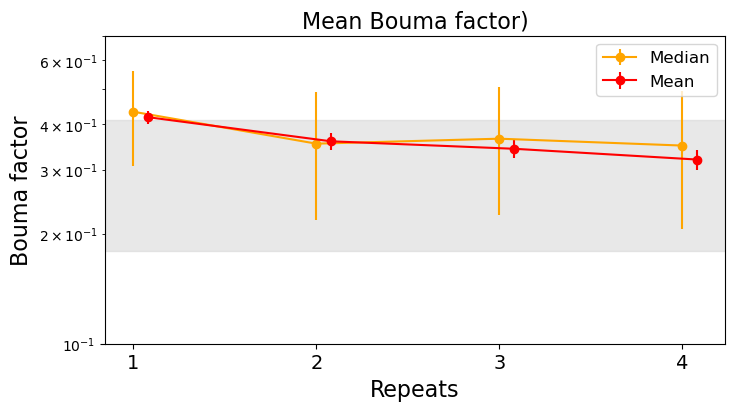

In [ ]:
plot_mean_thresholds(df_crowding, var_name="Bouma factor", ylims = [.1, .7])

# Kurzawski et al. (2025, Nature Comm) Data

In [ ]:
dir_natCom = 'data/kurzawski_2025_data.csv'
natCom_data = pd.read_csv(dir_natCom)
print(natCom_data.columns)

Index(['V1_R1_lh', 'V1_R2_lh', 'V2_R1_lh', 'V2_R2_lh', 'V3_R1_lh', 'V3_R2_lh',
       'V4_R1_lh', 'V4_R2_lh', 'V1_R1_rh', 'V1_R2_rh', 'V2_R1_rh', 'V2_R2_rh',
       'V3_R1_rh', 'V3_R2_rh', 'V4_R1_rh', 'V4_R2_rh', 'NLetters',
       'NLetters_S1', 'NLetters_S2', 'NLetters_RightMeridian',
       'NLetters_LeftMeridian', 'crowdingDist_Ecc5_Left_Meridian_Ses1',
       'crowdingDist_Ecc5_Left_Meridian_Ses2',
       'crowdingDist_Ecc5_Lower_Meridian_Ses1',
       'crowdingDist_Ecc5_Lower_Meridian_Ses2',
       'crowdingDist_Ecc5_Right_Meridian_Ses1',
       'crowdingDist_Ecc5_Right_Meridian_Ses2',
       'crowdingDist_Ecc5_Upper_Meridian_Ses1',
       'crowdingDist_Ecc5_Upper_Meridian_Ses2',
       'crowdingDist_Ecc10_Left_Meridian_Ses1',
       'crowdingDist_Ecc10_Left_Meridian_Ses2',
       'crowdingDist_Ecc10_Lower_Meridian_Ses1',
       'crowdingDist_Ecc10_Lower_Meridian_Ses2',
       'crowdingDist_Ecc10_Right_Meridian_Ses1',
       'crowdingDist_Ecc10_Right_Meridian_Ses2',
       'crowd

In [ ]:
# Create a new DataFrame with columns that start with 'crowdingDist'
natCom_crowding = natCom_data.filter(like='crowdingDist')
natCom_crowding_log = natCom_crowding.apply(np.log10)

natCom_crowding_avgRL_log = pd.DataFrame({
    'crowding_Ecc5_RL_Ses1': (natCom_crowding_log['crowdingDist_Ecc5_Left_Meridian_Ses1'] +
                              natCom_crowding_log['crowdingDist_Ecc5_Right_Meridian_Ses1']) / 2,
	'crowding_Ecc5_RL_Ses2': (natCom_crowding_log['crowdingDist_Ecc5_Left_Meridian_Ses2'] +
							  natCom_crowding_log['crowdingDist_Ecc5_Right_Meridian_Ses2']) / 2,
    'crowding_Ecc10_RL_Ses1': (natCom_crowding_log['crowdingDist_Ecc10_Left_Meridian_Ses1'] +
							  natCom_crowding_log['crowdingDist_Ecc10_Right_Meridian_Ses1']) / 2,
    'crowding_Ecc10_RL_Ses2': (natCom_crowding_log['crowdingDist_Ecc10_Left_Meridian_Ses2'] +
							  natCom_crowding_log['crowdingDist_Ecc10_Right_Meridian_Ses2']) / 2
})

In [ ]:
# Create a new DataFrame with the summed columns
natCom_data_map_sum = pd.DataFrame({
    'V1_R1': natCom_data['V1_R1_rh'] + natCom_data['V1_R1_lh'],
    'V1_R2': natCom_data['V1_R2_rh'] + natCom_data['V1_R2_lh'],
    'V2_R1': natCom_data['V2_R1_rh'] + natCom_data['V2_R1_lh'],
    'V2_R2': natCom_data['V2_R2_rh'] + natCom_data['V2_R2_lh'],
    'V3_R1': natCom_data['V3_R1_rh'] + natCom_data['V3_R1_lh'],
    'V3_R2': natCom_data['V3_R2_rh'] + natCom_data['V3_R2_lh'],
    'V4_R1': natCom_data['V4_R1_rh'] + natCom_data['V4_R1_lh'],
    'V4_R2': natCom_data['V4_R2_rh'] + natCom_data['V4_R2_lh']
})
natCom_data_map_sum_log = natCom_data_map_sum.apply(np.log10)


## Map size data

In [ ]:
df_for_analysis = natCom_data_map_sum_log.copy()
brain_prefixes = ['V1', 'V2', 'V3', 'V4']
                                  
brain_df = gather_results(df_for_analysis, brain_prefixes)
display(brain_df)

variance_df = pd.concat([variance_df, brain_df], ignore_index=True)

,task,within_subj_variance,btw_subj_variance,mean,r_ceiling
0,V1,0.000556,0.007229,3.448854,0.962393
1,V2,0.000505,0.004018,3.432388,0.940514
2,V3,0.001997,0.005033,3.315249,0.846299
3,V4,0.004003,0.010480,2.947784,0.836813


## Crowding data

In [ ]:
df_for_analysis = natCom_crowding_avgRL_log.copy()
task_prefixes = ['crowding_Ecc5_RL', 'crowding_Ecc10_RL']

crowding_natcom_df = gather_results(df_for_analysis, task_prefixes)
display(crowding_natcom_df)

variance_df = pd.concat([variance_df, crowding_natcom_df], ignore_index=True)

,task,within_subj_variance,btw_subj_variance,mean,r_ceiling
0,crowding_Ecc5_RL,0.004324,0.017300,0.008261,0.914395
1,crowding_Ecc10_RL,0.003429,0.014616,0.391177,0.880993


## Correlate crowding and V4

In [ ]:
V4_size = (natCom_data_map_sum_log['V4_R1'] + natCom_data_map_sum_log['V4_R2']) / 2
crowding_10deg = (natCom_crowding_avgRL_log['crowding_Ecc10_RL_Ses1'] +
                 natCom_crowding_avgRL_log['crowding_Ecc10_RL_Ses2']) / 2

# correlate V4 and crowding
measured_corr_V4_crowding = pearsonr(V4_size, crowding_10deg)
print(f'Correlation between V4 size and crowding at 10 deg: {measured_corr_V4_crowding[0]:.3f}, p-value: {measured_corr_V4_crowding[1]:.3f}')

# get noise ceiling for crowding and V4
r_ceiling_crowding_10deg = variance_df.loc[variance_df['task'] == 'crowding_Ecc10_RL', 'r_ceiling'].values[0]
r_ceiling_V4 = variance_df.loc[variance_df['task'] == 'V4', 'r_ceiling'].values[0]
print(f'Noise ceiling for crowding at 10 deg: {r_ceiling_crowding_10deg:.3f}')
print(f'Noise ceiling for V4 size: {r_ceiling_V4:.3f}')

# correction for noise ceiling
r_ceil = np.sqrt(r_ceiling_crowding_10deg * r_ceiling_V4)
corrected_corr_V4_crowding = measured_corr_V4_crowding[0] / r_ceil
print(f'Corrected correlation between V4 size and crowding at 10 deg: {corrected_corr_V4_crowding:.3f}')

Correlation between V4 size and crowding at 10 deg: -0.559, p-value: 0.000
Noise ceiling for crowding at 10 deg: 0.881
Noise ceiling for V4 size: 0.837
Corrected correlation between V4 size and crowding at 10 deg: -0.652


# Save data

In [ ]:
variance_df.to_csv("variance_df.csv", index=False)